In [1]:
## For FLBay

from satpy import Scene, find_files_and_readers
from pyresample import create_area_def
from satpy.writers import get_enhanced_image
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from satpy import MultiScene
from satpy import available_readers
from satpy.multiscene import timeseries
from skimage import exposure

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable
from glob import glob
import xarray as xr
import pandas as pd
import numpy as np1
from pyresample import geometry, create_area_def
from satpy import Scene
from cartopy.mpl.geoaxes import GeoAxes
import cmocean
import cmocean.cm as cmo
import matplotlib.cm as cm
from matplotlib import ticker

In [2]:
olci_dir = '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel Truecolor/'
olci_xr_mf = xr.open_mfdataset(olci_dir+'*_radiance.nc', combine='by_coords')
olci_geo_coords = xr.open_dataset(olci_dir+'geo_coordinates.nc')
lat = olci_geo_coords.latitude.data
lon = olci_geo_coords.longitude.data



def select_channels_for_rgb(xarray, red_channel, green_channel, blue_channel):
    """ 
    Selects the channels / bands of a multi-dimensional xarray for red, green and blue composites.
    
    Parameters:
        xarray(xarray Dataset): xarray Dataset object that stores the different channels / bands.
        red_channel(str): Name of red channel to be selected
        green_channel(str): Name of green channel to be selected
        blue_channel(str): Name of blue channel to be selected

    Returns:
        Three xarray DataArray objects with selected channels / bands
    """  
    return xarray[red_channel], xarray[green_channel], xarray[blue_channel]
red, green, blue = select_channels_for_rgb(olci_xr_mf, 'Oa08_radiance', 'Oa06_radiance', 'Oa04_radiance')

def normalize(array):
    """ 
    Normalizes a numpy array / xarray DataArray object value to values between 0 and 1.
    
    Parameters:
        xarray(numpy array or xarray DataArray): xarray DataArray or numpy array object.

    Returns:
        Normalized array
    """ 
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

rgb = np.dstack((redn, greenn, bluen))

mesh_rgb = rgb[:, :, :]
colorTuple = mesh_rgb.reshape((mesh_rgb.shape[0] * mesh_rgb.shape[1]), 3)
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1)

def visualize_s3_pcolormesh(color_array, array, latitude, longitude, title):
    """ 
    Visualizes a numpy array (Sentinel-3 data) with matplotlib's 'pcolormesh' function as composite.
    
    Parameters:
        color_array (numpy MaskedArray): any numpy MaskedArray, e.g. loaded with the NetCDF library and the Dataset function
        longitude (numpy Array): array with longitude values
        latitude (numpy Array) : array with latitude values
        title (str): title of the resulting plot
    """
    fig=plt.figure(figsize=(5, 9))
    lat_0, lon_0 = 24.125, -81

    ax=plt.axes(projection=ccrs.LambertConformal(central_longitude=lon_0, central_latitude=lat_0))
    ax.set_extent([-81.25, -80.75, 25.5, 24.75]) # Mediterranean
    
    

#     gl = ax.gridlines(draw_labels=True, linestyle='--')
#     gl.xlabels_top=False
#     gl.ylabels_right=False
#     gl.xformatter=LONGITUDE_FORMATTER
#     gl.yformatter=LATITUDE_FORMATTER
#     gl.xlabel_style={'size':14}
#     gl.ylabel_style={'size':14}
    
    img1 = plt.pcolormesh(longitude, latitude, array*np.nan, color=colorTuple,
                          clip_on = True,
                          edgecolors=None,
                          zorder=0,
                          transform=ccrs.PlateCarree()
                          )
    ax.set_title(title, fontsize=20, pad=20.0)
    plt.savefig('/home/hboi-ouri/Downloads/16March2023.png')
    plt.show()

/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


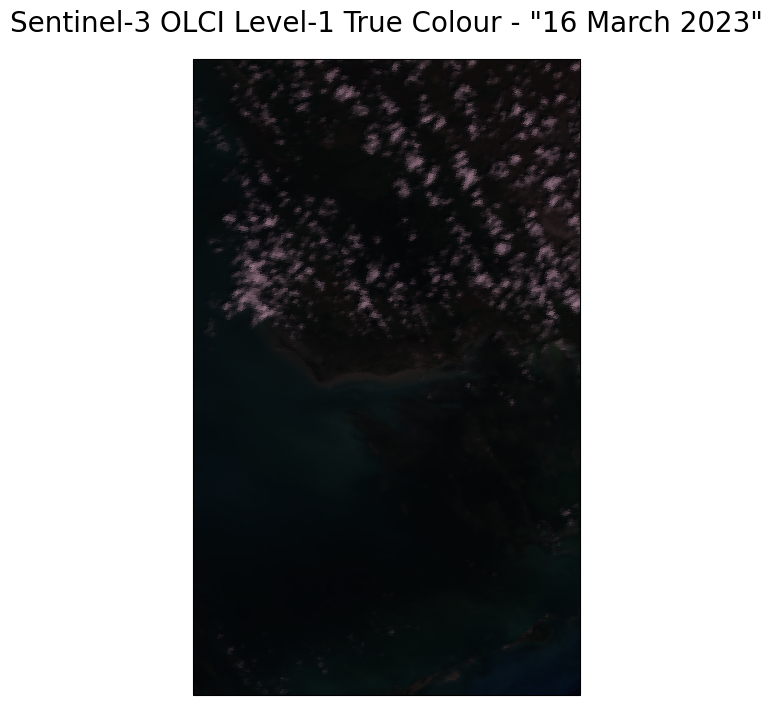

In [3]:
visualize_s3_pcolormesh(color_array=colorTuple,
                        array=red, 
                        latitude=lat, 
                        longitude=lon, 
                        title='Sentinel-3 OLCI Level-1 True Colour - "16 March 2023"')

In [5]:
##for TXLA

from satpy import Scene, find_files_and_readers
from pyresample import create_area_def
from satpy.writers import get_enhanced_image
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from satpy import MultiScene


def TXLAfigure(monthyear):
    
    #files to be used
    filenames = glob('/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel Truecolor/*')
    
    #area in the figure
    extent = [-81.25, -80.75, 25.5, 24.75]
    my_area = create_area_def('my_area', {'proj': 'lcc', 'lon_0': -81, 'lat_0': 25.125, 
                                          'lat_1': 25.125, 'lat_2': 25.125},
                width=1500, height=750,
                area_extent=extent, units='degrees')    
        
    fig =  plt.figure(figsize=(6, 4), dpi=400)

    #loop
    for swat in swats:
        scn = Scene(filenames, reader='olci_l1b')
        scn.load(['true_color'])

        #reproject
        new_scn = scn.resample(my_area)

        #generate RGB from true color
        rgb = get_enhanced_image(new_scn['true_color'])

        #extract projection and lon lat from products
        crs = new_scn['true_color'].attrs['area'].to_cartopy_crs()
        lons, lats = new_scn['true_color'].attrs['area'].get_lonlats()

        #true color
        ax1 = plt.subplot(projection=crs)
        rgb.data.plot.imshow(rgb='bands', transform=crs, ax=ax1)

        
        #title & save
        ax1.set_title('MODISA_Mdelta_%s' % new_scn.start_time.isoformat())
        fig.savefig('/home/hboi-ouri/Projects/NASA_ProjectExp/outputs/DailyImages/TXLA/MODISA_Mdelta_%s_rgb.png' % new_scn.start_time.isoformat())
        fig.clear()

In [21]:
files = find_files_and_readers(sensor='olci',

                               base_dir="/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel Truecolor/",
                               reader='olci_l1b')
 
scn = Scene(filenames=files)
scn.load(['true_color'])

ValueError: No supported files found

In [24]:
sorted(available_readers())

['abi_l1b',
 'abi_l1b_scmi',
 'abi_l2_nc',
 'acspo',
 'agri_l1',
 'ahi_hrit',
 'ahi_hsd',
 'ahi_l1b_gridded_bin',
 'ami_l1b',
 'amsr2_l1b',
 'amsr2_l2',
 'amsr2_l2_gaasp',
 'amsub_l1c_aapp',
 'ascat_l2_soilmoisture_bufr',
 'avhrr_l1b_aapp',
 'avhrr_l1b_eps',
 'avhrr_l1b_hrpt',
 'avhrr_l1c_eum_gac_fdr_nc',
 'clavrx',
 'cmsaf-claas2_l2_nc',
 'electrol_hrit',
 'fci_l1c_nc',
 'fci_l2_nc',
 'generic_image',
 'geocat',
 'ghrsst_l2',
 'glm_l2',
 'goes-imager_hrit',
 'goes-imager_nc',
 'gpm_imerg',
 'hy2_scat_l2b_h5',
 'iasi_l2',
 'iasi_l2_so2_bufr',
 'jami_hrit',
 'maia',
 'mersi2_l1b',
 'mhs_l1c_aapp',
 'mimicTPW2_comp',
 'mirs',
 'modis_l1b',
 'modis_l2',
 'msu_gsa_l1b',
 'mtsat2-imager_hrit',
 'mviri_l1b_fiduceo_nc',
 'nucaps',
 'nwcsaf-geo',
 'nwcsaf-msg2013-hdf5',
 'nwcsaf-pps_nc',
 'oceancolorcci_l3_nc',
 'olci_l1b',
 'olci_l2',
 'omps_edr',
 'safe_sar_l2_ocn',
 'satpy_cf_nc',
 'seadas_l2',
 'seviri_l1b_hrit',
 'seviri_l1b_icare',
 'seviri_l1b_native',
 'seviri_l1b_nc',
 'seviri_l2_bufr

In [ ]:
from satpy.scene import Scene
from satpy import find_files_and_readers
from datetime import datetime
 
extent = [-81.25, -80.75, 25.5, 24.75]

files = find_files_and_readers(sensor='olci',
                               start_time=datetime(2023, 5, 4, 15, 14),
                               end_time=datetime(2023, 5, 4, 15, 17),
                               base_dir="/home/hboi-ouri/Downloads/S3A_OL_1_EFR____20230504T151442_20230504T151742_20230505T193906_0180_098_239_2520_MAR_O_NT_002.SEN3",
                               reader='olci_l1b')
 
    
my_area = create_area_def('my_area', {'proj': 'lcc', 'lon_0': -81, 'lat_0': 25.125, 
                                      'lat_1': 25.125, 'lat_2': 25.125},
            width=1500, height=750,
            area_extent=extent, units='degrees')    

fig =  plt.figure(figsize=(6, 4), dpi=400)
scn = Scene(filenames=files)
scn.load(['true_color'])

new_scn = scn.resample(my_area)
print('1')
#generate RGB from true color
rgb = get_enhanced_image(new_scn['true_color'])

crs = new_scn['true_color'].attrs['area'].to_cartopy_crs()
lons, lats = new_scn['true_color'].attrs['area'].get_lonlats()
print('2')
#true color
ax1 = plt.subplot(projection=crs)
rgb.data.plot.imshow(rgb='bands', transform=crs, ax=ax1)
# scn.save_dataset('true_color', filename='/home/hboi-ouri/Downloads/true_color_gnc_tutorial'+'.png')


1
2


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in log
  return func(*(_execute_task(a, cache) for a in args))
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/satpy/modifiers/angles.py:502: RuntimeWarning: invalid value encountered in log
  grad_factor = 1. - np.log(grad_factor + 1) / np.log(2)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in log
  return func(*(_execute_task(a, cache) for a in args))
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/satpy/modifiers/angles.py:502: RuntimeWarning: invalid value encountered in log
  grad_factor = 1. - np.log(grad_factor + 1) / np.log(2)


In [6]:
olci_dir = '/home/hboi-ouri/Downloads/S3A_OL_1_EFR____20230615T152551_20230615T152851_20230616T161737_0179_100_068_2520_PS1_O_NT_003.SEN3/'
olci_xr_mf = glob(olci_dir+'*_radiance.nc')

print(olci_xr_mf)






['/home/hboi-ouri/Downloads/S3A_OL_1_EFR____20230615T152551_20230615T152851_20230616T161737_0179_100_068_2520_PS1_O_NT_003.SEN3/Oa05_radiance.nc', '/home/hboi-ouri/Downloads/S3A_OL_1_EFR____20230615T152551_20230615T152851_20230616T161737_0179_100_068_2520_PS1_O_NT_003.SEN3/Oa04_radiance.nc', '/home/hboi-ouri/Downloads/S3A_OL_1_EFR____20230615T152551_20230615T152851_20230616T161737_0179_100_068_2520_PS1_O_NT_003.SEN3/Oa12_radiance.nc', '/home/hboi-ouri/Downloads/S3A_OL_1_EFR____20230615T152551_20230615T152851_20230616T161737_0179_100_068_2520_PS1_O_NT_003.SEN3/Oa09_radiance.nc', '/home/hboi-ouri/Downloads/S3A_OL_1_EFR____20230615T152551_20230615T152851_20230616T161737_0179_100_068_2520_PS1_O_NT_003.SEN3/Oa01_radiance.nc', '/home/hboi-ouri/Downloads/S3A_OL_1_EFR____20230615T152551_20230615T152851_20230616T161737_0179_100_068_2520_PS1_O_NT_003.SEN3/Oa14_radiance.nc', '/home/hboi-ouri/Downloads/S3A_OL_1_EFR____20230615T152551_20230615T152851_20230616T161737_0179_100_068_2520_PS1_O_NT_003.S